In [1]:
'''
Learning the dynamics of simple phyisical systems from images using principal component analysis
'''

'\nLearning the dynamics of simple phyisical systems from images using principal component analysis\n'

In [2]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import skimage.transform as st
import seaborn as sns
from skimage.util import img_as_ubyte
from skimage.filters import gaussian
import cv2

sns.set()

In [3]:
def preproc(X):
    r, g, b = X[:,:,0], X[:,:,1], X[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    img_where = np.where((200 > gray) & (gray > 50), 255, 0)
    img = img_as_ubyte(img_where)
    out = st.resize(img, (28, 28))
    out = 1.0 * (out > 0.2)

    return out

In [4]:
def get_theta(obs):
    '''Transforms coordinate basis from the defaults of the gym pendulum env.'''
    theta = np.arctan2(obs[0], -obs[1])
    theta = theta + np.pi/2
    theta = theta + 2*np.pi if theta < -np.pi else theta
    theta = theta - 2*np.pi if theta > np.pi else theta
    return theta

In [5]:
%%time
seed = 0
timesteps = 100 #100
trials = 10 #5
min_angle = 0
max_angle = np.pi / 2

gym_settings = locals()

env = gym.make('Pendulum-v0')
env.reset()
env.seed(seed)

canonical_coords, frames = [], []
for step in range(trials * timesteps):

    if step % timesteps == 0:
        angle_ok = False

        while not angle_ok:
            obs = env.reset()
            theta_init = np.abs(get_theta(obs))
            
            if theta_init > min_angle and theta_init < max_angle:
                angle_ok = True
            
    frames.append(preproc(env.render('rgb_array')))
    obs = env.step([0.])[0]
    theta, dtheta = get_theta(obs), obs[-1]

    canonical_coords.append(np.array([theta, 0.25 * dtheta]) )

env.close()

canonical_coords = np.stack(canonical_coords).reshape(trials*timesteps, -1)
frames = np.array(frames)


C:\Users\szcsm\anaconda3\envs\myenv\lib\site-packages\skimage\util\dtype.py:525: UserWarning: Downcasting int32 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)
Wall time: 1min 4s


Text(0.5, 1.0, 'Simulated data')

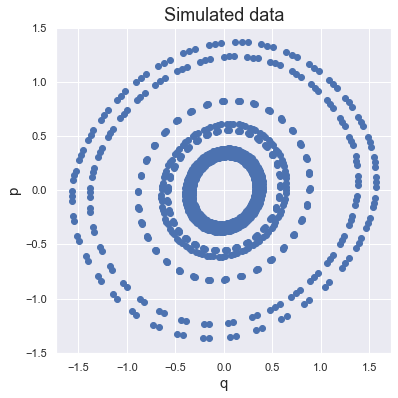

In [6]:
plt.figure(figsize=(6, 6))

plt.plot(canonical_coords[:,0], canonical_coords[:,1], 'o')
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.title('Simulated data', size=18)

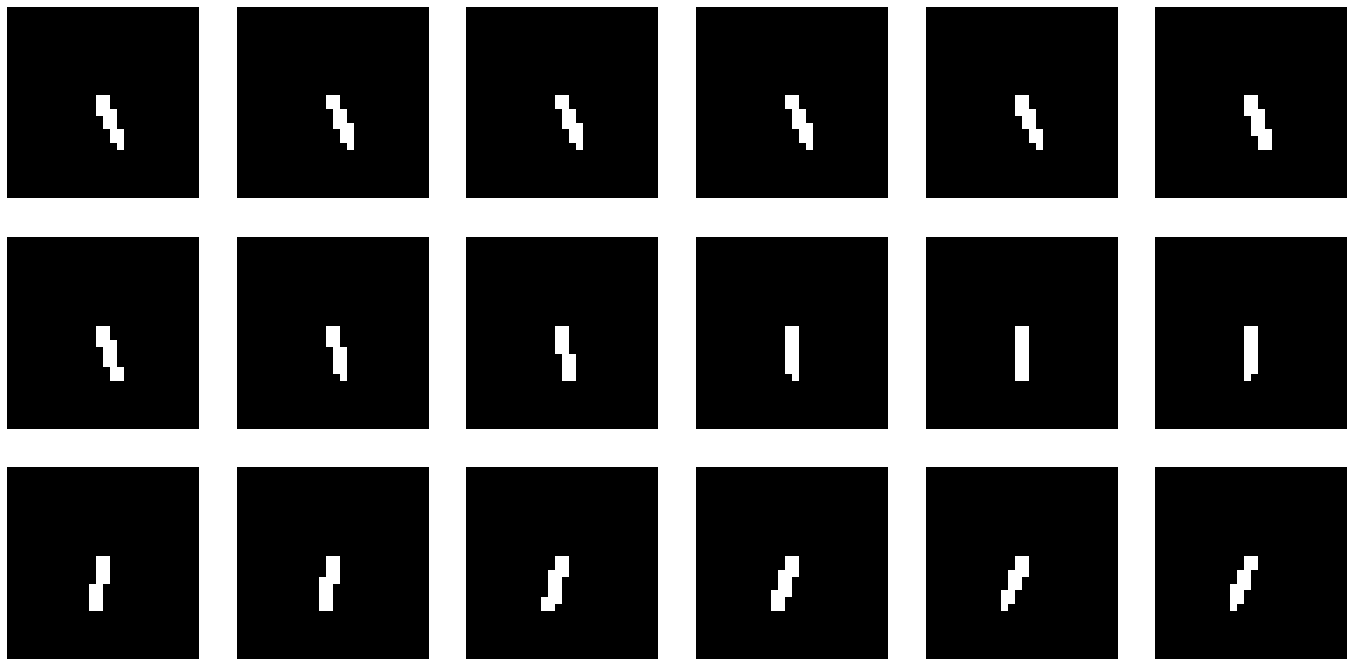

<Figure size 432x288 with 0 Axes>

In [7]:
w=10
h=10
fig=plt.figure(figsize=(24, 12))
columns = 6
rows = 3
for i in range(1, columns*rows +1):
    img = frames[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()
plt.tight_layout()


(500, 56, 28)

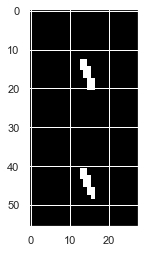

In [8]:
concated = np.concatenate((frames[::2], frames[1::2]), axis=1)
plt.imshow(concated[0], cmap='gray')
concated.shape

In [9]:
'''
temp1 = np.expand_dims(frames[::2], axis=3)
temp2 = np.expand_dims(frames[1::2], axis=3)
motblur = np.concatenate((temp1, temp2), axis=3)
motblur = np.concatenate((motblur, temp2), axis=3)
plt.imshow(motblur[0])
'''

'\ntemp1 = np.expand_dims(frames[::2], axis=3)\ntemp2 = np.expand_dims(frames[1::2], axis=3)\nmotblur = np.concatenate((temp1, temp2), axis=3)\nmotblur = np.concatenate((motblur, temp2), axis=3)\nplt.imshow(motblur[0])\n'

In [10]:
data = concated.reshape(int(trials * timesteps/2), 28*28*2)

In [46]:
 from sklearn.decomposition import PCA


 pca = PCA(n_components=4)

In [47]:
embedding = pca.fit_transform(data)

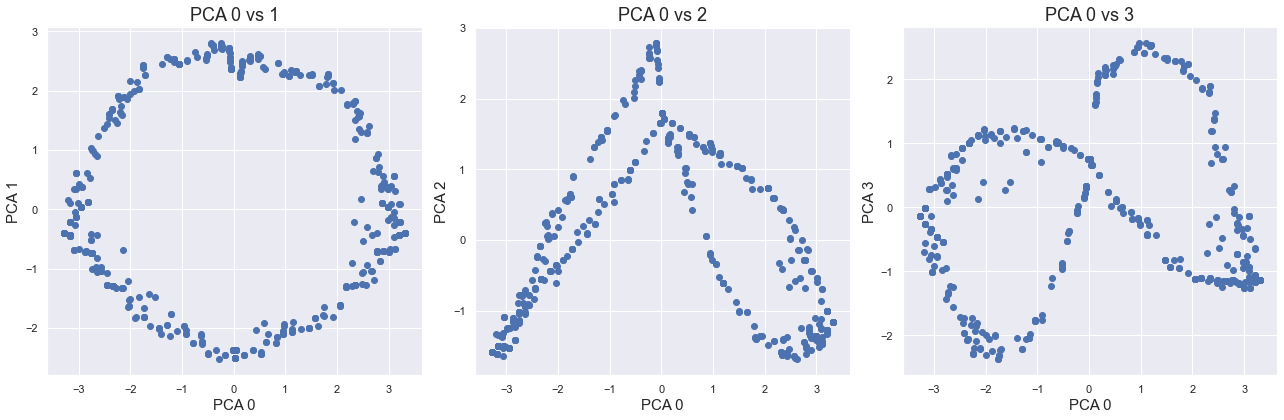

In [48]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.scatter(embedding[:,0], embedding[:,1])
plt.xlabel('PCA 0', size=15)
plt.ylabel('PCA 1', size=15)
plt.title('PCA 0 vs 1', size=18)

plt.subplot(132)
plt.scatter(embedding[:,0], embedding[:,2])
plt.xlabel('PCA 0', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA 0 vs 2', size=18)

plt.subplot(133)
plt.scatter(embedding[:,0], embedding[:,3])
plt.xlabel('PCA 0', size=15)
plt.ylabel('PCA 3', size=15)
plt.title('PCA 0 vs 3', size=18)

plt.tight_layout()


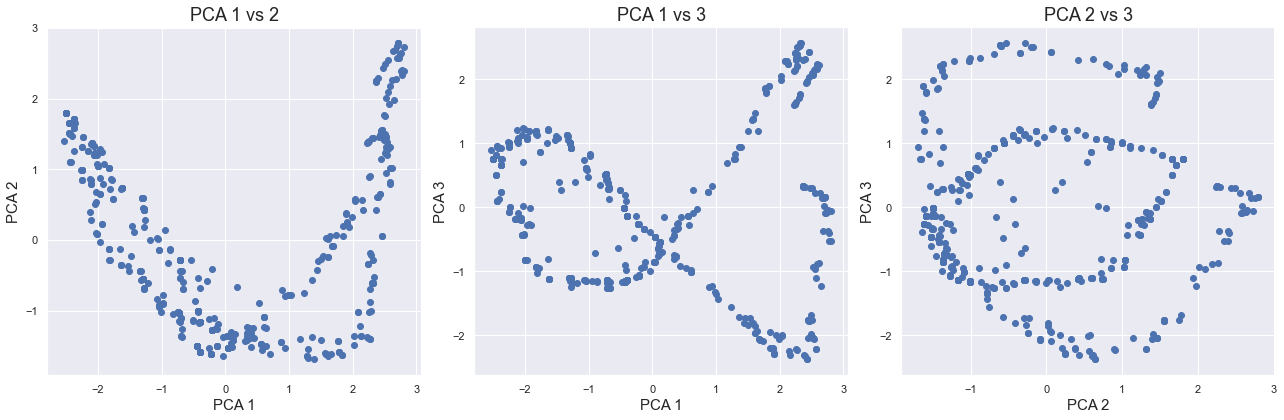

In [49]:
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.scatter(embedding[:,1], embedding[:,2])
plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 2', size=15)
plt.title('PCA 1 vs 2', size=18)

plt.subplot(132)
plt.scatter(embedding[:,1], embedding[:,3])
plt.xlabel('PCA 1', size=15)
plt.ylabel('PCA 3', size=15)
plt.title('PCA 1 vs 3', size=18)

plt.subplot(133)
plt.scatter(embedding[:,2], embedding[:,3])
plt.xlabel('PCA 2', size=15)
plt.ylabel('PCA 3', size=15)
plt.title('PCA 2 vs 3', size=18)

plt.tight_layout()

In [50]:
import plotly.express as px


fig = px.scatter_3d(x=embedding[:,0], y=embedding[:,1], z=embedding[:,2])
fig.show()